# Projeto 2

Aplicação de Modelos de Regressão para Predição de Tráfego de Redes 4G/LTE com Scikit-Learn

- **Aluno**: Guilherme Rodriguez Vicentin
- **E-mail**: vicentingr@gmail.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Análise inicial dos dados

### Importando o CSV

In [65]:
df = pd.read_csv('LTE_network_traffic.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,CellName,Traffic,DateTime
0,Cell_001803,15.13867,2017-10-23 07:00:00
1,Cell_002303,2.05516,2017-10-23 02:00:00
2,Cell_004083,71.55308,2017-10-23 07:00:00
3,Cell_003781,557.98491,2017-10-23 00:00:00
4,Cell_000112,0.98166,2017-10-23 03:00:00


### Contando as células

In [3]:
cell_values = df['CellName'].value_counts()
print(f"Número de células disponíveis: {cell_values.count()}")
print(f"Média de tráfego {df['Traffic'].mean()}")
cell_values

Número de células disponíveis: 57
Média de tráfego 533.4913117296667


CellName
Cell_004071    8903
Cell_000112    8902
Cell_001912    8902
Cell_001801    8902
Cell_001913    8902
Cell_000822    8901
Cell_000821    8901
Cell_001802    8901
Cell_001911    8901
Cell_003792    8901
Cell_001961    8901
Cell_006661    8901
Cell_003783    8901
Cell_003791    8901
Cell_006653    8901
Cell_001031    8901
Cell_000823    8901
Cell_003793    8901
Cell_039872    8901
Cell_039873    8900
Cell_006652    8900
Cell_004081    8900
Cell_007373    8900
Cell_003782    8900
Cell_001963    8900
Cell_001032    8900
Cell_000462    8900
Cell_039871    8900
Cell_000463    8900
Cell_001803    8900
Cell_002301    8900
Cell_002302    8900
Cell_002303    8900
Cell_004073    8900
Cell_000111    8900
Cell_007372    8900
Cell_004083    8900
Cell_003781    8900
Cell_000113    8900
Cell_006663    8900
Cell_001033    8900
Cell_006651    8900
Cell_000232    8899
Cell_004082    8899
Cell_000231    8899
Cell_007371    8899
Cell_000461    8899
Cell_001962    8899
Cell_004072    8899
Cell_000233

### Correlação

<Axes: >

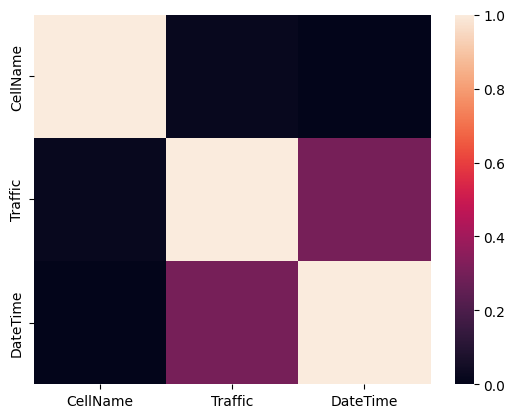

In [66]:
import seaborn as sns
from sklearn import preprocessing

# Converte strings usando LabelEncoder
cell_le = preprocessing.LabelEncoder()
df['CellName'] = cell_le.fit_transform(df['CellName'])
# Converte strings usando datetime
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')

sns.heatmap(df.corr())

Conseguimos entrar uma correlação de 0.303571 entre *Traffic* e *Datetime*. E de 0.019925 entre *CellName* e *Traffic*.

In [18]:
df.corr()

,CellName,Traffic,DateTime
CellName,1.000000,0.019925,-0.000022
Traffic,0.019925,1.000000,0.303571
DateTime,-0.000022,0.303571,1.000000


## Filtrando os dados

### Visualização antes

<Axes: >

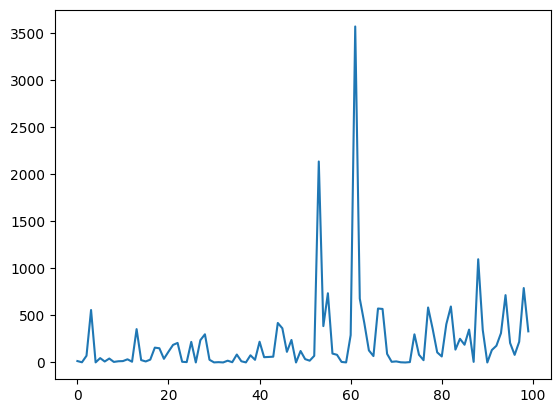

In [16]:
df['Traffic'].iloc[:100].plot()

### Visualização depois do filtro

<Axes: >

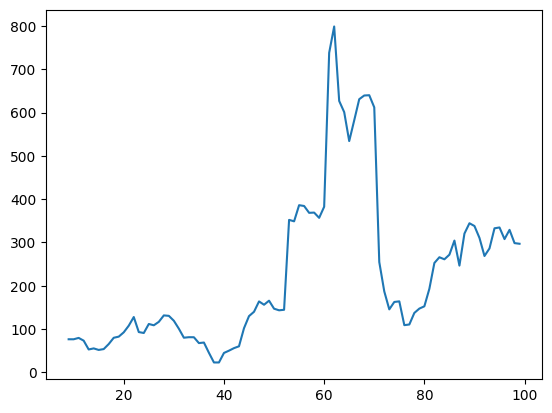

In [67]:
df['Traffic'] = df['Traffic'].rolling(10).mean()
df['Traffic'].iloc[:100].plot()

## Definição de target

In [25]:
df_cell = df.copy()
df_cell.drop('CellName', axis=1, inplace=True)
df_cell.tail()

,Traffic,DateTime
507058,1020.202649,2018-10-22 23:00:00
507059,1438.468349,2018-10-22 23:00:00
507060,1295.000995,2018-10-22 23:00:00
507061,1271.000290,2018-10-22 23:00:00
507062,1304.069310,2018-10-22 23:00:00


In [26]:
df_cell['Y'] = df_cell['Traffic'].shift(-1)
df_cell.dropna(inplace=True)
df_cell.tail()

,Traffic,DateTime,Y
507057,785.135915,2018-10-22 23:00:00,1020.202649
507058,1020.202649,2018-10-22 23:00:00,1438.468349
507059,1438.468349,2018-10-22 23:00:00,1295.000995
507060,1295.000995,2018-10-22 23:00:00,1271.000290
507061,1271.000290,2018-10-22 23:00:00,1304.069310


## Definição da sequência

In [27]:
seq_len = 3

for i in range(seq_len):
    df_cell[f'Traffic - {i+1}'] = df_cell['Traffic'].shift(i+1)
    
df_cell.dropna(inplace=True)
df_cell.head()

,Traffic,DateTime,Y,Traffic - 1,Traffic - 2,Traffic - 3
12,73.300251,2017-10-23 03:00:00,52.967727,79.650933,76.480248,76.517206
13,52.967727,2017-10-23 06:00:00,55.417438,73.300251,79.650933,76.480248
14,55.417438,2017-10-23 01:00:00,51.871753,52.967727,73.300251,79.650933
15,51.871753,2017-10-23 03:00:00,53.863242,55.417438,52.967727,73.300251
16,53.863242,2017-10-23 06:00:00,65.459424,51.871753,55.417438,52.967727


### Visualizando sequência

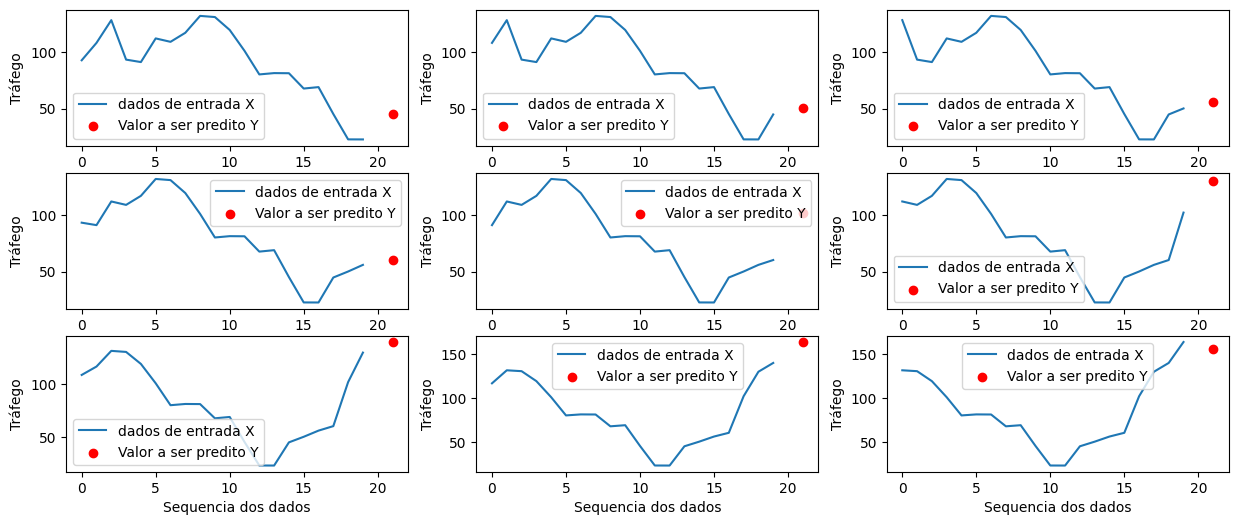

In [28]:
import matplotlib.pyplot as plt
seq = 20
inicio = seq

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))
for linha in range(3):
    for coluna in range(3):
        x = df['Traffic'].iloc[inicio:inicio + seq]
        y = df['Traffic'].iloc[inicio + seq]
        
        ax[linha, coluna].plot(range(seq), x, label='dados de entrada X')
        ax[linha, coluna].scatter(len(x) + 1, y, label='Valor a ser predito Y', color='r')
        ax[linha, coluna].legend()
        ax[linha, coluna].set_xlabel('Sequencia dos dados')
        ax[linha, coluna].set_ylabel('Tráfego')
        inicio += 1

## Normalização

### Separação X e Y

In [29]:
Y = df_cell['Y'].values
df_cell.drop('Y', axis=1, inplace=True)

range_datetime = df_cell['DateTime']
df_cell.drop('DateTime', axis=1, inplace=True)

X = df_cell.values

print(f'Len X: {len(X)}, Len Y: {len(Y)}')

Len X: 507050, Len Y: 507050


### Normalização com min-máx

In [30]:
from sklearn.preprocessing import MinMaxScaler

X_normalizer = MinMaxScaler()
Y_normalizer = MinMaxScaler()

X = X_normalizer.fit_transform(X)
Y = Y_normalizer.fit_transform(Y.reshape(-1, 1))

Y

array([[0.01398953],
       [0.01466209],
       [0.01368864],
       ...,
       [0.35498496],
       [0.34839566],
       [0.35747464]])

## Separação de dados de treino e teste

In [31]:
sep = int(len(X) * 0.8)
print(f'Separador: {sep}')

x_training = X[ :sep]
y_training = Y[ :sep]

x_test = X[sep: ]
y_test = Y[sep: ]

print(f'Len x_test: {len(x_test)}, Len y_test: {len(y_test)}')

Separador: 405640
Len x_test: 101410, Len y_test: 101410


## Treinamento do regressor

### Regressor linear

In [32]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_training, y_training)

pred_lr = lr.predict(x_test)
lr.score(x_test, y_test)

0.9418087665812691

### KNN

In [33]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_training, y_training)
pred_knn = knn.predict(x_test) 
knn.score(x_test, y_test)

0.912830221787046

### Support Vector Regression (SVM)

In [ ]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(x_training, y_training.ravel())
pred_svr = svr.predict(x_test)
svr.score(x_test, y_test.ravel())

### Decision Tree (DT)

In [34]:
from sklearn import tree

dt = tree.DecisionTreeRegressor()
dt.fit(x_training, y_training)
pred_dt = dt.predict(x_test) 
dt.score(x_test, y_test)

0.8855678816563113

### Stochastic Gradient Descent

In [35]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
sgd.fit(x_training, y_training.ravel())
pred_sgd = sgd.predict(x_test) 
sgd.score(x_test, y_test.ravel())

0.9171338328433805

## Visualização dos resultados

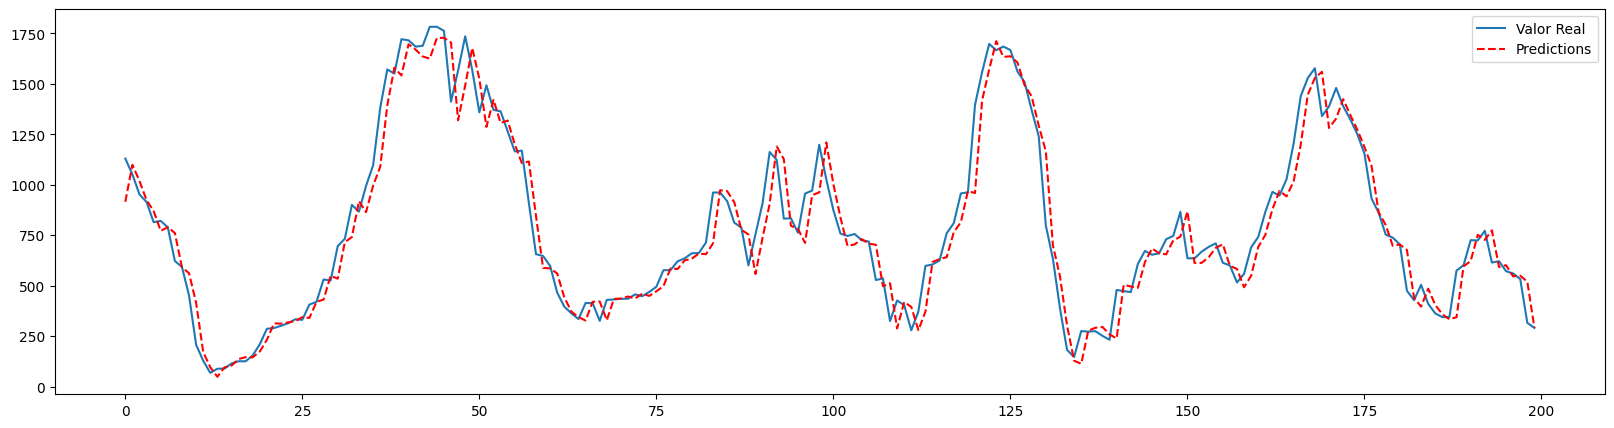

In [52]:
import matplotlib.pyplot as plt
quantidate_predicoes = 200

y_teste_ori = Y_normalizer.inverse_transform(y_test.reshape(-1, 1))
pred_lr_ori = Y_normalizer.inverse_transform(pred_lr.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(20, 5))
#dates   = noted_date[separador:]
dates   = range(len(y_teste_ori[:quantidate_predicoes]))


ax.plot(dates, y_teste_ori[:quantidate_predicoes], label='Valor Real')
ax.plot(dates, pred_lr_ori[:quantidate_predicoes], label='Predictions', color='r', linestyle='--')
plt.legend()

## Comparação de desempenho de diferentes modelos de regressão

### MSE

In [61]:
from sklearn.metrics import mean_squared_error

mse_lr = mean_squared_error(pred_lr, y_test)
mse_knn = mean_squared_error(pred_knn, y_test)
mse_dt = mean_squared_error(pred_dt, y_test)
mse_sgd = mean_squared_error(pred_sgd, y_test)

print(f"MSE Linear Regression: {mse_lr}")
print(f"MSE KNN: {mse_knn}")
print(f"MSE Decision Tree: {mse_dt}")
print(f"MSE SGD: {mse_sgd}")

MSE Linear Regression: 0.0010409546395299656
MSE KNN: 0.0015593377168108772
MSE Decision Tree: 0.0020470204445393733
MSE SGD: 0.0014823525141844315


<BarContainer object of 4 artists>

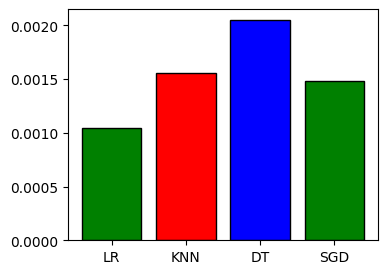

In [62]:
mse_dict = {
    'LR' : mse_lr,
    'KNN' : mse_knn,
    'DT' : mse_dt,
    'SGD' : mse_sgd
}

fig, ax = plt.subplots(figsize=(4, 3))

ax.bar(mse_dict.keys(), mse_dict.values(), color=['green', 'red', 'blue'], edgecolor='k')

### MAE

In [48]:
from sklearn.metrics import mean_absolute_error

mae_lr = mean_absolute_error(pred_lr, y_test)
mae_knn = mean_absolute_error(pred_knn, y_test)
mae_dt = mean_absolute_error(pred_dt, y_test)
mae_sgd = mean_absolute_error(pred_sgd, y_test)

print(f"MAE Linear Regression: {mse_lr}")
print(f"MAE KNN: {mse_knn}")
print(f"MAE Decision Tree: {mse_dt}")
print(f"MAE SGD: {mse_sgd}")

MAE Linear Regression: 0.022510101533173878
MAE KNN: 0.028231679728945608
MAE Decision Tree: 0.03264339665800396
MAE SGD: 0.027769368218575223


<BarContainer object of 4 artists>

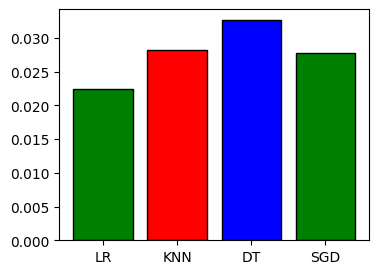

In [58]:
mae_dict = {
    'LR' : mae_lr,
    'KNN' : mae_knn,
    'DT' : mae_dt,
    'SGD' : mae_sgd
}

fig, ax = plt.subplots(figsize=(4, 3))

ax.bar(mae_dict.keys(), mae_dict.values(), color=['green', 'red', 'blue'], edgecolor='k')

### RMSE

In [57]:
import math

pred_lr_ori = Y_normalizer.inverse_transform(pred_lr.reshape(-1, 1))
rmse_lr = math.sqrt(mean_squared_error(pred_lr_ori, y_teste_ori))
print(f"RMSE Linear Regression: {rmse_lr}")

pred_knn_ori = Y_normalizer.inverse_transform(pred_knn.reshape(-1, 1))
rmse_knn = math.sqrt(mean_squared_error(pred_knn_ori, y_teste_ori))
print(f"RMSE KNN: {rmse_knn}")

pred_dt_ori = Y_normalizer.inverse_transform(pred_dt.reshape(-1, 1))
rmse_dt = math.sqrt(mean_squared_error(pred_dt_ori, y_teste_ori))
print(f"RMSE DT: {rmse_dt}")

pred_sgd_ori = Y_normalizer.inverse_transform(pred_sgd.reshape(-1, 1))
rmse_sgd = math.sqrt(mean_squared_error(pred_sgd_ori, y_teste_ori))
print(f"RMSE SGD: {rmse_sgd}")

RMSE Linear Regression: 117.51696564254674
RMSE KNN: 143.83174796604592
RMSE DT: 164.79565491678605
RMSE SGD: 140.2362899758162


<BarContainer object of 4 artists>

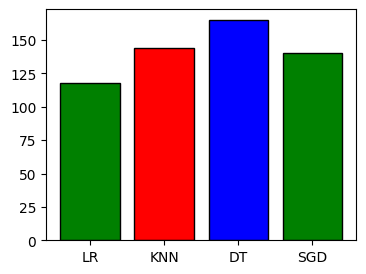

In [63]:
mae_dict = {
    'LR' : rmse_lr,
    'KNN' : rmse_knn,
    'DT' : rmse_dt,
    'SGD' : rmse_sgd
}

fig, ax = plt.subplots(figsize=(4, 3))

ax.bar(mae_dict.keys(), mae_dict.values(), color=['green', 'red', 'blue'], edgecolor='k')

## Diferente tamanho de sequência

In [79]:
df_new_seq = df.copy()
df_new_seq.drop('CellName', axis=1, inplace=True)
df_new_seq['Y'] = df_new_seq['Traffic'].shift(-1)
df_new_seq.dropna(inplace=True)
df_new_seq.tail()

,Traffic,DateTime,Y
507057,785.135915,2018-10-22 23:00:00,1020.202649
507058,1020.202649,2018-10-22 23:00:00,1438.468349
507059,1438.468349,2018-10-22 23:00:00,1295.000995
507060,1295.000995,2018-10-22 23:00:00,1271.000290
507061,1271.000290,2018-10-22 23:00:00,1304.069310


In [77]:
seq_len = 10

for i in range(seq_len):
    df_new_seq[f'Traffic - {i+1}'] = df_new_seq['Traffic'].shift(i+1)
    
df_new_seq.dropna(inplace=True)
df_new_seq.head()

,Traffic,DateTime,Traffic - 1,Traffic - 2,Traffic - 3,Traffic - 4,Traffic - 5,Traffic - 6,Traffic - 7,Traffic - 8,Traffic - 9,Traffic - 10
19,82.569172,2017-10-23 08:00:00,79.975207,65.459424,53.863242,51.871753,55.417438,52.967727,73.300251,79.650933,76.480248,76.517206
20,92.554537,2017-10-23 08:00:00,82.569172,79.975207,65.459424,53.863242,51.871753,55.417438,52.967727,73.300251,79.650933,76.480248
21,107.866392,2017-10-23 08:00:00,92.554537,82.569172,79.975207,65.459424,53.863242,51.871753,55.417438,52.967727,73.300251,79.650933
22,127.859054,2017-10-23 10:00:00,107.866392,92.554537,82.569172,79.975207,65.459424,53.863242,51.871753,55.417438,52.967727,73.300251
23,93.134120,2017-10-23 08:00:00,127.859054,107.866392,92.554537,82.569172,79.975207,65.459424,53.863242,51.871753,55.417438,52.967727


In [80]:
Y = df_new_seq['Y'].values
df_new_seq.drop('Y', axis=1, inplace=True)

range_datetime = df_new_seq['DateTime']
df_new_seq.drop('DateTime', axis=1, inplace=True)

X = df_new_seq.values

print(f'Len X: {len(X)}, Len Y: {len(Y)}')

Len X: 507053, Len Y: 507053


In [81]:
from sklearn.preprocessing import MinMaxScaler

X_normalizer = MinMaxScaler()
Y_normalizer = MinMaxScaler()

X = X_normalizer.fit_transform(X)
Y = Y_normalizer.fit_transform(Y.reshape(-1, 1))

Y

array([[0.0204448 ],
       [0.0213153 ],
       [0.01957175],
       ...,
       [0.35498496],
       [0.34839566],
       [0.35747464]])

In [82]:
sep = int(len(X) * 0.8)
print(f'Separador: {sep}')

x_training = X[ :sep]
y_training = Y[ :sep]

x_test = X[sep: ]
y_test = Y[sep: ]

print(f'Len x_test: {len(x_test)}, Len y_test: {len(y_test)}')

Separador: 405642
Len x_test: 101411, Len y_test: 101411


In [83]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_training, y_training)

pred_lr = lr.predict(x_test)
lr.score(x_test, y_test)

0.9400209763120333

Rodando o Linear Regression com um tamnho de sequência maior não apresentou melhoras, inclusive se saiu um pouco pior com ~0.94 de score.